<a href="https://colab.research.google.com/github/annvorosh/GB/blob/NLP/NLP_L04_thematic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук `parse_rospotrebnadzor.ipynb`
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [1]:
import requests
from bs4 import BeautifulSoup
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm

In [5]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]

urls = []
for page in tqdm(range(1, 1000), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

Pages:   0%|          | 0/999 [00:00<?, ?it/s]

In [6]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text
def get_text_page_answer(soup):
    return soup.findAll('p', {'class':'appeal-comments-message'})[0].text

question = []
answers = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))
    soup = BeautifulSoup(res.text)

    question.append(get_text_page_question(soup))
    try:
        answers.append(get_text_page_answer(soup))
    except:
        answers.append('No answer')

Pages:   0%|          | 0/4995 [00:00<?, ?it/s]

In [7]:
## посмотрим, что скачалось
N = 2
print('Q:', question[N])
print()
print('A:', answers[N])

Q: Добрый день!
Приобрёл телефон в магазине Мвидео телефон SF Huawei P60 PRO 8/256GB, по условиям акции от производителя в подарок к нему шли часы стоимостью 15000 рублей и бонусы от магазина продавца. По условиям сделки товар должен быть выдан 09 июня 2023 г, что было зафиксировано в заявке на выдачу товара. 09 июля я пришёл получить оплаченный товар, но в магазине мне выдать его отказались, сказав, что товар не пришёл. Поскольку 10 числа я уезжал в отпуск, я был вынужден отказаться от товара и вернуть деньги, тем самым утратив право на получения выгоды в размере порядка 25000 рублей. 

Я обратился с претензией в Магазин (во вложении) и получил ответ с предложением компенсации 10% от суммы убытков.
Такая компенсация меня не устраивает. т.к убытки и моральный вред из за просрочки выдачи товара значительно выше.
В каком порядке возможно далее продолжать отстаивать свои права и требовать выплату компенсации? Какова вероятность получения компенсации с учётом сложившейся ситуации?

Мою пре

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import re
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem



In [10]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
!pip install pymorphy2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 45.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=0849ad37e6f16f4de454cf2c965edf58273024b454887bdb5d9a77a14ae62559
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [13]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [96]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
!tar -xvf mystem-3.1-linux-64bit.tar.gz
!mv mystem /usr/local/bin


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--2023-07-25 12:58:07--  http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.242, 5.45.205.243, 5.45.205.244, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.242|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz?lid=122 [following]
--2023-07-25 12:58:08--  http://cachev2-spb02.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz?lid=122
Resolving cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)... 37.9.93.113, 2a02:6b8:117:5::113
Connecting to cachev2-spb02.cdn.yandex.net (cachev2-spb02.cdn.yandex.net)|37.9.93.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36635786 (35M) [application/octet-stream]
Saving to: ‘mystem-3.1-linux-64bit.tar.gz’

mystem-3.1-linux-64 100%[===================>

In [97]:
stopwords_list = set(stopwords.words('russian'))

# Инициализация лемматизатора
morph = pymorphy2.MorphAnalyzer()

# Регулярное выражение для поиска слов
words_regex = re.compile(r'\w+')

# def process_text(text, stopwords_list=stopwords_list, lemmer=morph):
#     # Приведение к нижнему регистру
#     text = text.lower()

#     # Токенизация и удаление стоп-слов и символов
#     tokens = words_regex.findall(text)
#     words = [word for word in tokens if word.isalpha() and len(word) >= 3 and word not in stopwords_list]

#     # Лемматизация
#     lemmas = [lemmer.parse(word)[0].normal_form for word in words]

#     return lemmas


def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

mystem = Mystem()
def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
    lemmas = lemmer.lemmatize(' '.join(words))
    return [w for w in lemmas if not w in stopwords
            and w.isalpha()]

# def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
#     lemmas = [lemmer.parse(w)[0].normal_form for w in words]
#     return [w for w in lemmas if not w in stopwords
#             and w.isalpha()]

def process_text(text):
    return (lemmatize(find_words(text)))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Py

In [98]:
# Обработка вопросов
preprocessed_questions = [process_text(text) for text in question]

# Пример обработки второго текста вопроса
print(preprocessed_questions[1])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['здравствовать', 'год', 'сделать', 'заказ', 'wildberries', 'сумма', 'тенге', 'заказывать', 'сапог', 'артикул', 'год', 'данный', 'заказ', 'зависать', 'статус', 'принимать', 'сортировочный', 'центр', 'астана', 'момент', 'писать', 'обращение', 'служба', 'поддержка', 'каждый', 'давать', 'верный', 'информация', 'сначала', 'писать', 'отменять', 'вернуть', 'средство', 'деньги', 'перечислять', 'это', 'банк', 'потерять', 'сбой', 'приложение', 'скоро', 'восстанавливать', 'вернуть', 'деньги', 'год', 'статус', 'заказ', 'изменяться', 'замена', 'склад', 'электросталь', 'снова', 'появляться', 'статус', 'отсортировывать', 'астана', 'сей', 'день', 'писать', 'отписка', 'настаивать', 'ждать', 'товар', 'который', 'нужный', 'стоимость', 'низко', 'платить', 'сезон', 'месяц', 'твориться', 'хаос', 'просить', 'помогать', 'вернуть', 'средство', 'защищать', 'право', 'потребитель', 'это', 'сайт', 'телефон', 'обращение', 'поддержка', 'чат', 'консультант', 'который', 'писать', 'отписка', 'весь', 'обращение', 'напи

In [99]:
!pip install -U gensim
from gensim.models import *
from gensim import corpora

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
# Создание словаря и корпуса
dictionary = corpora.Dictionary(preprocessed_questions)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря
dictionary.save('rospotreb.dict')

corpus = [dictionary.doc2bow(text) for text in preprocessed_questions]
corpora.MmCorpus.serialize('rospotreb.model', corpus)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 5.24 s, sys: 44.3 ms, total: 5.29 s
Wall time: 5.55 s


In [102]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.032*"деньги" + 0.029*"день" + 0.029*"заказ" + 0.029*"возврат" + 0.016*"вернуть" + 0.016*"доставка" + 0.015*"средство" + 0.015*"сайт" + 0.014*"ответ" + 0.012*"билет"'),
 (1,
  '0.036*"цена" + 0.025*"магазин" + 0.023*"адрес" + 0.019*"ценник" + 0.018*"сертификат" + 0.018*"продукция" + 0.013*"кассир" + 0.012*"цвет" + 0.012*"точка" + 0.011*"справка"'),
 (2,
  '0.047*"рубль" + 0.036*"сумма" + 0.029*"карта" + 0.028*"оплата" + 0.025*"руб" + 0.023*"банк" + 0.019*"счет" + 0.019*"оплачивать" + 0.015*"цена" + 0.014*"размер"'),
 (3,
  '0.027*"просить" + 0.026*"магазин" + 0.024*"данный" + 0.021*"это" + 0.017*"принимать" + 0.014*"продукт" + 0.014*"адрес" + 0.013*"продавать" + 0.013*"проверка" + 0.013*"здравствовать"'),
 (4,
  '0.046*"договор" + 0.045*"услуга" + 0.026*"компания" + 0.019*"предоставлять" + 0.017*"данный" + 0.017*"март" + 0.015*"год" + 0.013*"связь" + 0.013*"номер" + 0.012*"оператор"'),
 (5,
  '0.046*"ребенок" + 0.025*"год" + 0.025*"тур" + 0.017*"норма" + 0.016*"мусор" + 0.014*

In [103]:
# !pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [104]:

import pyLDAvis.gensim_models
# Визуализация результатов с помощью LDAvis
lda_vis_data = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(lda_vis_data, 'lda_visualization.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from IPython.display import display, HTML

# Путь к файлу HTML-визуализации LDAvis
lda_visualization_path = 'lda_visualization.html'

# Открываем и отображаем визуализацию LDA
with open(lda_visualization_path, 'r') as f:
    html_content = f.read()
    display(HTML(html_content))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

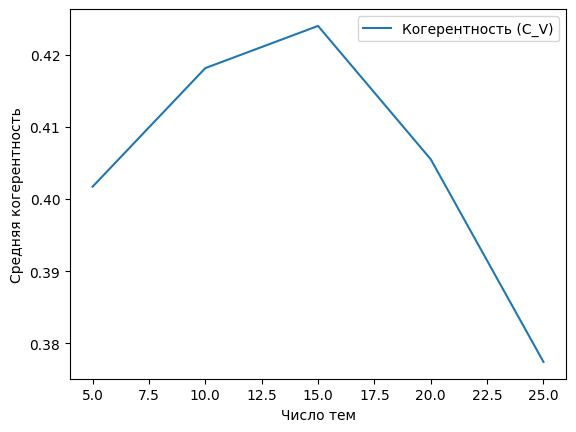

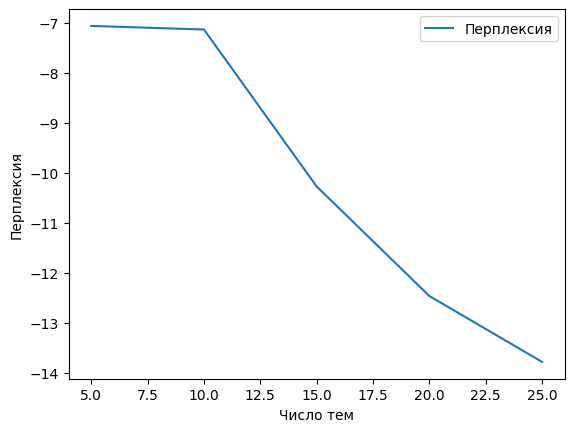

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

topics_list = [5, 10, 15, 20, 25]
coherences = []
perplexities = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=preprocessed_questions, dictionary=dictionary, coherence='c_v').get_coherence())
    perplexities.append(lda.log_perplexity(corpus))

# График когерентности
plt.plot(topics_list, coherences, label="Когерентность (C_V)")
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.legend()
plt.show()

# График перплексии
plt.plot(topics_list, perplexities, label="Перплексия")
plt.xlabel("Число тем")
plt.ylabel("Перплексия")
plt.legend()
plt.show()



Судя по графику когерентности стоит выбрать 15 тем.

### Выполнение LDA на биграммах

In [108]:
# Создание биграмм из униграмм
bigram = Phrases(preprocessed_questions, min_count=5, threshold=10)

# Обработка текстов вопросов с биграммами
texts_bigrams = [bigram[q] for q in preprocessed_questions]

# Создание словаря и корпуса для биграмм:
dictionary_bigram = Dictionary(texts_bigrams)
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in texts_bigrams]



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [109]:
# Выполнение LDA на биграммах:
num_topics = 10  # Количество тематик для биграмм
lda_model_bigram = LdaModel(corpus=corpus_bigram, id2word=dictionary_bigram, num_topics=num_topics, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
# Визуализация результатов с помощью LDAvis
lda_vis_data_bigram = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)
pyLDAvis.save_html(lda_vis_data_bigram, 'lda_bigram_visualization.html')

# Путь к файлу HTML-визуализации LDAvis
lda_bigram_visualization_path = 'lda_bigram_visualization.html'

# Открываем и отображаем визуализацию LDA
with open(lda_bigram_visualization_path, 'r') as f:
    html_content = f.read()
    display(HTML(html_content))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Вычислим перплексию и когерентность для каждой модели:

In [111]:
perplexity = lda.log_perplexity(corpus)
perplexity_bigram = lda_model_bigram.log_perplexity(corpus_bigram)
print("Perplexity (Unigram):", perplexity)
print("Perplexity (Bigram):", perplexity_bigram)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity (Unigram): -13.78609973163743
Perplexity (Bigram): -8.916679030827869


In [112]:
from gensim.models import CoherenceModel

coherence_model_unigram = CoherenceModel(model=lda, texts=preprocessed_questions, dictionary=dictionary, coherence='u_mass') # так как с_v для биграмм не работает
coherence_unigram = coherence_model_unigram.get_coherence()
print("Coherence (Unigram):", coherence_unigram)

coherence_model_bigram = CoherenceModel(model=lda_model_bigram, texts=preprocessed_questions, dictionary=dictionary_bigram, coherence='u_mass') # так как с_v для биграмм не работает
coherence_bigram = coherence_model_bigram.get_coherence()
print("Coherence (Bigram):", coherence_bigram)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence (Unigram): -3.0598254143267996
Coherence (Bigram): -2.618722868310364


Когерентность для обеих моделей (униграмм и биграмм) примерно одинаковая. Однако, сами значения -3.018 для униграмм и -3.007 для биграмм достаточно низкие, что может указывать на то, что модели не обнаруживают явных тематических связей в данных.